In [9]:
import os
import pandas as pd
from PIL import Image, ImageFile
import torch
import lpips
from torchvision import transforms
from pytorch_msssim import ms_ssim
import matplotlib.pyplot as plt
import math
import numpy as np

# ---------------- Metric Functions ----------------
def calculate_psnr(original, recon, resolution):
    transform = transforms.Compose([transforms.CenterCrop(resolution), transforms.ToTensor()])
    img1 = transform(Image.open(original).convert("RGB")).unsqueeze(0).clamp(0, 1)
    img2 = transform(Image.open(recon).convert("RGB")).unsqueeze(0).clamp(0, 1)
    mse = torch.mean((img1 - img2) ** 2)
    return float('inf') if mse == 0 else 10 * torch.log10(1.0 / mse).item()

def calculate_ms_ssim(original, recon, resolution):
    transform = transforms.Compose([transforms.CenterCrop(resolution), transforms.ToTensor()])
    img1 = transform(Image.open(original).convert("RGB")).unsqueeze(0).clamp(0, 1)
    img2 = transform(Image.open(recon).convert("RGB")).unsqueeze(0).clamp(0, 1)
    return ms_ssim(img1, img2, data_range=1.0, size_average=True).item()

def calculate_lpips(original, recon, resolution):
    model = lpips.LPIPS(net='alex')
    transform = transforms.Compose([transforms.CenterCrop(resolution), transforms.ToTensor()])
    img1 = transform(Image.open(original).convert("RGB")).unsqueeze(0)
    img2 = transform(Image.open(recon).convert("RGB")).unsqueeze(0)
    return model(img1, img2).item()

# ---------------- Model Condition Mapping ----------------
model_conditions = {
    "adaptive_codebook_4d_512k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "4", "k": "512"},
    "adaptive_codebook_4d_1024k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "4", "k": "1024"},
    "adaptive_codebook_2d_256k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "2", "k": "256"},
    "adaptive_codebook_2d_512k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "2", "k": "512"},
    "adaptive_wo_codebook": {"Adaptive": "TRUE", "CodebookUsed": "FALSE"},
    "wo_adaptive_codebook_4d_512k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "4", "k": "512"},
    "wo_adaptive_codebook_4d_1024k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "4", "k": "1024"},
    "wo_adaptive_codebook_2d_256k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "2", "k": "256"},
    "wo_adaptive_codebook_2d_512k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "2", "k": "512"},
    "wo_adaptive_wo_codebook": {"Adaptive": "FALSE", "CodebookUsed": "FALSE"},
}

# ---------------- Main Function ----------------
def compare_models(image_path, model_labels):
    df = pd.read_excel("results_summary.xlsx")
    image_name = os.path.splitext(os.path.basename(image_path))[0].lower()

    primary_df = df[df['ImagePath'].str.lower() == image_name].copy()
    fallback_df = df[df['ImagePath'].str.lower() == 'default_image'].copy()

    use_fallback = primary_df.empty
    df = fallback_df if use_fallback else primary_df

    if df.empty:
        print("No matching rows in Excel.")
        return

    selected = []
    for label in model_labels:
        cond = model_conditions.get(label)
        if cond is None:
            print(f"Unknown model label: {label}")
            continue

        rows = df[
            (df['Adaptive'].astype(str).str.upper() == cond['Adaptive']) &
            (df['CodebookUsed'].astype(str).str.upper() == cond['CodebookUsed'])
        ]
        # if 'd' in cond:
        #     rows = rows[rows['d'].astype(str) == cond['d']]
        # if 'k' in cond:
        #     rows = rows[rows['k'].astype(str) == cond['k']]

        if 'd' in cond:
            rows = rows[rows['d'] == int(cond['d'])]
        if 'k' in cond:
            rows = rows[rows['k'] == int(cond['k'])]

        if not rows.empty:
            selected.append((label, rows.iloc[0]))

    if not selected:
        print("No models matched.")
        return

    # --- Plot ---
    # fig, axes = plt.subplots(1, len(selected) + 1, figsize=(5 * (len(selected) + 1), 5))

    max_per_row = 3
    total_plots = len(selected) + 1  # +1 for original
    rows = math.ceil(total_plots / max_per_row)
    cols = min(total_plots, max_per_row)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    # axes = axes.flatten() if rows > 1 else [axes]  # flatten for consistent indexing
    axes = np.array(axes).flatten().tolist()



    axes[0].imshow(Image.open(image_path))
    axes[0].set_title("Original")
    axes[0].axis('off')

    for idx, (label, row) in enumerate(selected):
        recon_path = row['ReconPath']
        with Image.open(recon_path) as img:
            resolution = img.size[::-1]  # (H, W)
        binary_size = float(row['BinarySizeKB'])

        if use_fallback:
            # Calculate fresh
            psnr = calculate_psnr(image_path, recon_path, resolution)
            ssim = calculate_ms_ssim(image_path, recon_path, resolution)
            lp = calculate_lpips(image_path, recon_path, resolution)
            orig_size = os.path.getsize(image_path) / 1024
            cr = orig_size / binary_size if binary_size else 0
        else:
            psnr = row['PSNR']
            ssim = row['MS-SSIM']
            lp = row['LPIPS']
            cr = row['CompressionRatio']

        axes[idx + 1].imshow(Image.open(recon_path))
        axes[idx + 1].set_title(
            f"{label}\nPSNR: {psnr:.2f} dB\nMS-SSIM: {ssim:.4f}\nLPIPS: {lp:.4f}\nCompression Ratio: {cr:.2f}"
        )
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# compare_models(
#     "Datasets/Kodak/kodim23.png",
#     [
#         "wo_adaptive_wo_codebook",
#         "wo_adaptive_codebook_4d_512k",
#         "wo_adaptive_codebook_2d_256k",
#         "adaptive_codebook_4d_512k",
#         "adaptive_codebook_2d_256k",
#         "adaptive_wo_codebook",
#     ]
# )


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Python311\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Python311\cv\Lib\site-packages\lpips\weights\v0.1\alex.pth


c:\Python311\cv\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), strict=F

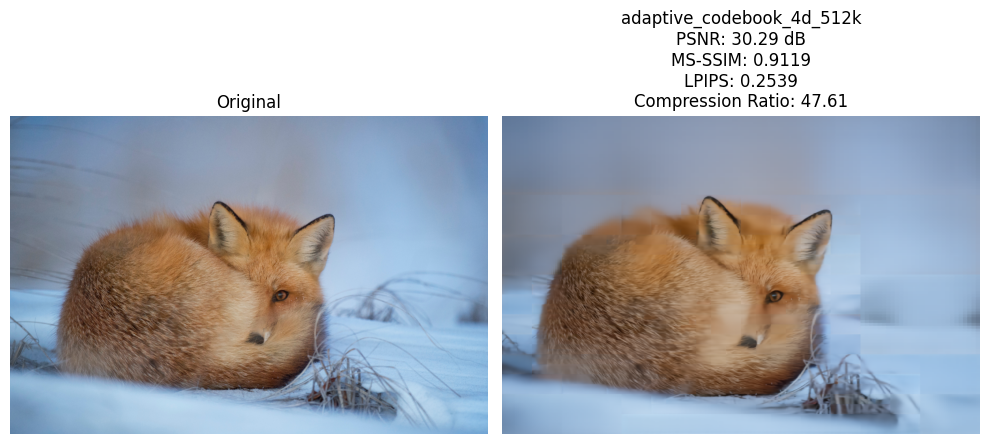

In [15]:
compare_models(
    "./Datasets/Div2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png",
    [
        "wo_adaptive_wo_codebook",
        "wo_adaptive_codebook_4d_512k",
        "wo_adaptive_codebook_2d_256k",
        "adaptive_codebook_4d_512k",
        "adaptive_codebook_2d_256k",
        "adaptive_wo_codebook",
    ]
)
